In [1]:
# using environment opencv
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage import feature

import numpy as np
import argparse
import cv2
import os
import pickle
import keras

from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D , Flatten, Dense, Dropout
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import numpy as np

Using TensorFlow backend.


In [2]:
def quantify_image(image):
    # compute the histogram of oriented gradients feature vector for
    # the input image
    features = feature.hog(image, orientations=9,
        pixels_per_cell=(10, 10), cells_per_block=(2, 2),
        transform_sqrt=True, block_norm="L1")

    # return the feature vector
    return features

def load_split(path):
    # grab the list of images in the input directory, then initialize
    # the list of data (i.e., images) and class labels
    imagePaths = os.listdir(path)
    data = []
    labels = []

    # loop over the image paths
    for imagePath in imagePaths:
        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]

        # load the input image, convert it to grayscale, and resize
        # it to 200x200 pixels, ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (224, 224))

        # threshold the image such that the drawing appears as white
        # on a black background
        image = cv2.threshold(image, 0, 255,
            cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        # quantify the image
        features = quantify_image(image)

        # update the data and labels lists, respectively
        data.append(features)
        labels.append(label)

    # return the data and labels
    return (np.array(data), np.array(labels))





In [4]:
# define the path to the training and testing directories
dataset_wave='C:/Users/zecharpy/Downloads/parkinsons/dataset/spiral/'
trainingPath = dataset_wave+ "training/"
testingPath = dataset_wave+"testing/"


def get_data(data_path, use_opencv=True):
    X=[]
    Y=[]
    # loop through each image path and fetch the features, then write to index per row 
    #for ext in ('*.gif', '*.png', '*.jpg','*.jpeg'):
    label_paths=['healthy','parkinson']
    for label_path in label_paths:
        img_dir=data_path+label_path
        img_files=os.listdir(img_dir)
        if label_path=='healthy':
            ls=[ Y.append(0) for i in range(len(img_files))]
        else:
            ls=[ Y.append(1) for i in range(len(img_files))]
        for img in img_files:
            img=cv2.imread(data_path+label_path+'/'+img)
            img=cv2.resize(img,(224,224))
            if use_opencv:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                #

                img = cv2.threshold(img, 0, 255,
                cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

                # quantify the image
                features = quantify_image(img)
                print(features.shape)
                X.append(features)
            else:
                img=img/255
                X.append(img)
                
    Y=np.array(Y)
    X=np.array(X)
    return X, Y

X_train, y_train=get_data(trainingPath)
X_test,y_test=get_data(testingPath )
X2train, y2train=get_data(trainingPath,False)
X2test,y2test=get_data(testingPath, False )

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X2train.shape, X2test.shape, y2train.shape, y2test.shape

(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)
(15876,)


((72, 15876),
 (72,),
 (30, 15876),
 (30,),
 (72, 224, 224, 3),
 (30, 224, 224, 3),
 (72,),
 (30,))

## prepare a feed-forward neural network focus on recall as metric

In [5]:
# cosntruct custom metrics for monitoring 
from keras import backend as K
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score


def precision(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    return precision


def recall(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    recall = c1 / c3

    return recall

In [10]:
import keras
from keras.models import Sequential # use to initialize our NN
from keras.layers import Dense # create hidden layers 
from keras.layers import Dropout

# Initialising the NN
classifier = Sequential()

# Adding the input layer and the first hidden layer
#relu is rectifier function for the hidden layer
# check out different activation function provided in keras : keras.io/activations/
classifier.add(Dense(units = 5120, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15876)) # input_dim equal to the number of features we have , look at X_train we have 11 features 
classifier.add(Dropout(rate=0.4))
# Adding the second hidden layer
classifier.add(Dense(units = 1024, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate=0.2))
classifier.add(Dense(units = 512, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate=0.2))
# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
# also checkout optimizer function, need to provide a loss function in order to do optimization :keras.io/optimizers/
# adam =first order gradient-based optimization of stochastic objective functions
# metric choices check out here : keras.io/metrics/
classifier.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall, f1_score])

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
epochs=25
early_stop = EarlyStopping(monitor='val_acc', 
                           min_delta=0.001, 
                           patience=10, 
                           mode='max', 
                           verbose=1)

checkpoint = ModelCheckpoint('FC_spiral_parkinson.h5', 
                             monitor='val_recall', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             period=1)

classifier.fit(X_train,y_train, batch_size=24,validation_data=(X_test,y_test),
                    callbacks=[early_stop,checkpoint], epochs=epochs, shuffle=True)


Train on 72 samples, validate on 30 samples
Epoch 1/25
72/72 [==============================] - 5s 70ms/step - loss: 0.7408 - acc: 0.5139 - precision: 0.6667 - recall: 0.6667 - f1_score: 0.4894 - val_loss: 0.9889 - val_acc: 0.5000 - val_precision: nan - val_recall: 0.0000e+00 - val_f1_score: nan

Epoch 00001: val_recall improved from -inf to 0.00000, saving model to FC_spiral_parkinson.h5
Epoch 2/25
72/72 [==============================] - 3s 42ms/step - loss: 0.4282 - acc: 0.7917 - precision: 0.9375 - recall: 0.6846 - f1_score: 0.7035 - val_loss: 0.5521 - val_acc: 0.8000 - val_precision: 0.6800 - val_recall: 1.0000 - val_f1_score: 0.8000

Epoch 00002: val_recall improved from 0.00000 to 1.00000, saving model to FC_spiral_parkinson.h5
Epoch 3/25
72/72 [==============================] - 3s 43ms/step - loss: 0.2622 - acc: 0.8750 - precision: 0.9524 - recall: 0.8056 - f1_score: 0.8371 - val_loss: 0.6924 - val_acc: 0.7667 - val_precision: 0.6500 - val_recall: 1.0000 - val_f1_score: 0.7760


In [74]:
#classifier.save("FC_spiral_parkinson.h5")

dataset_wave='C:/Users/zecharpy/Downloads/parkinsons/dataset/spiral/'
trainingPath = dataset_wave+ "training/"
testingPath = dataset_wave+"testing/"
Xtrain=[]
Xtest=[]
# loop through each image path and fetch the features, then write to index per row 
#for ext in ('*.gif', '*.png', '*.jpg','*.jpeg'):
def get_img(path):
    X=[]
    Y=[]
    label_paths=['healthy','parkinson']
    for label_path in label_paths:
        img_dir=path+label_path
        img_files=os.listdir(img_dir)
        if label_path=='healthy':
            ls=[ Y.append(0) for i in range(len(img_files))]
        else:
            ls=[ Y.append(1) for i in range(len(img_files))]
        for img in img_files:
            img=cv2.imread(path+label_path+'/'+img)
            img=cv2.resize(img,(224,224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            X.append(img)
    Y=np.array(Y)
    X=np.array(X)
    return X,Y

Xtrain,Ytrain=get_img(trainingPath)
Xtest,Ytest=get_img(testingPath)
Xtrain=Xtrain.reshape(72,224,224,1)
Xtest=Xtest.reshape(42,224,224,1)
Xtrain.shape, Xtest.shape,Ytrain.shape,Ytest.shape

((72, 224, 224, 1), (42, 224, 224, 1), (72,), (42,))

## prepare and trained a transfer-learning Neural Network based on VGG16 as base_model 

In [71]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.applications.resnet50 import ResNet50
img_width, img_height = 224, 224
num_classes=1

# Initialising the CNN
model = Sequential()

# Step 1 - Convolution
model.add(Conv2D(32, (3, 3), input_shape = (224, 224,1), activation = 'relu', padding="same"))

# Step 2 - Pooling
model.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))


# Adding a second convolutional layer
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
model.add(Flatten())

# Step 4 - Full connection
model.add(Dense(units = 1024, activation = 'relu')) # the output_dim is chosen by experience
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])



In [72]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 110, 110, 32)      9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 53, 53, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 32)        9248      
__________

### using data augmentation

In [75]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)
train_datagen.fit(Xtrain, augment=True, seed=123)
test_datagen.fit(Xtest, augment=True, seed=123)
train_batch=train_datagen.flow(Xtrain, Ytrain, batch_size=20, seed=123, shuffle=True )
test_batch=test_datagen.flow(Xtest, Ytest, batch_size=20, seed=123, shuffle=True )

In [76]:
# fits the model on batches with real-time data augmentation:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
epochs=100
early_stop = EarlyStopping(monitor='val_acc', 
                           min_delta=0.001, 
                           patience=10, 
                           mode='max', 
                           verbose=1)

checkpoint = ModelCheckpoint('CNN_spiral_parkinson.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             period=1)

model.fit_generator(train_batch,
                         steps_per_epoch = 24,
                         epochs = 100,
                         validation_data = test_batch,
                         callbacks=[early_stop,checkpoint]
                         )
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('CNN_parkinson.h5')

Epoch 1/100
24/24 [==============================] - 17s 710ms/step - loss: 0.7368 - acc: 0.4549 - val_loss: 0.6929 - val_acc: 0.6667

Epoch 00001: val_acc improved from -inf to 0.66667, saving model to CNN_spiral_parkinson.h5
Epoch 2/100
24/24 [==============================] - 14s 604ms/step - loss: 0.6932 - acc: 0.4751 - val_loss: 0.6931 - val_acc: 0.5000

Epoch 00002: val_acc did not improve
Epoch 3/100
24/24 [==============================] - 15s 615ms/step - loss: 0.6932 - acc: 0.4971 - val_loss: 0.6931 - val_acc: 0.5000

Epoch 00003: val_acc did not improve
Epoch 4/100
24/24 [==============================] - 15s 609ms/step - loss: 0.6930 - acc: 0.5154 - val_loss: 0.6927 - val_acc: 0.5238

Epoch 00004: val_acc did not improve
Epoch 5/100
24/24 [==============================] - 15s 615ms/step - loss: 0.6923 - acc: 0.5712 - val_loss: 0.6907 - val_acc: 0.5238

Epoch 00005: val_acc did not improve
Epoch 6/100
24/24 [==============================] - 15s 609ms/step - loss: 0.6855 - 

## train the model and save best weights based on validation recall 

In [82]:
#model.save('CNN_final_spiral_parkinson_model.h5')
from keras.models import load_model
m=load_model('CNN_final_spiral_parkinson_model.h5')

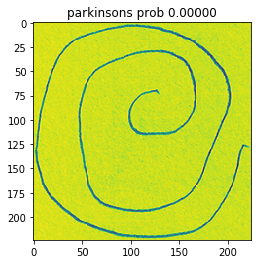

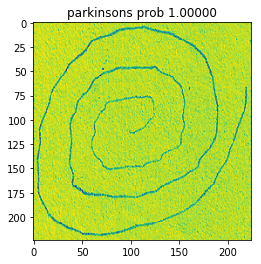

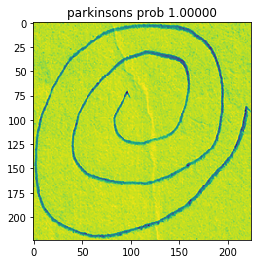

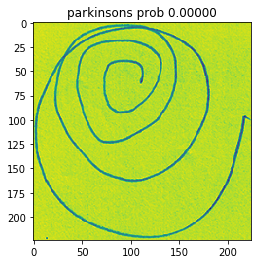

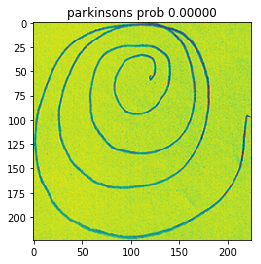

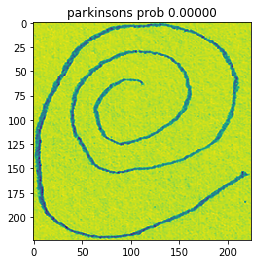

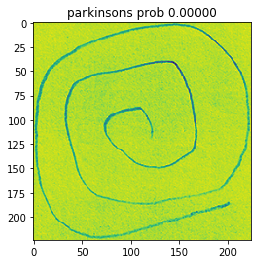

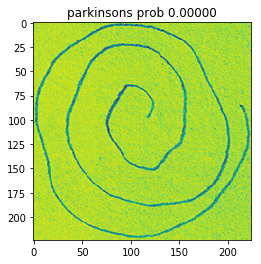

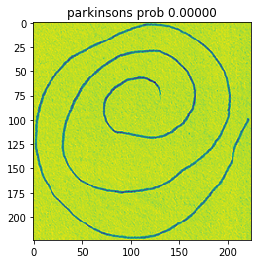

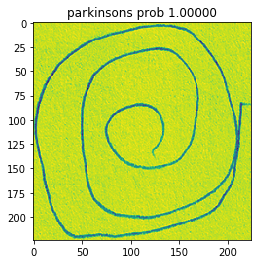

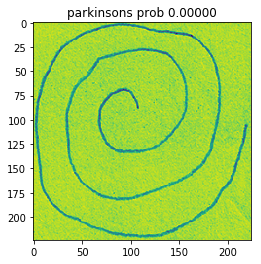

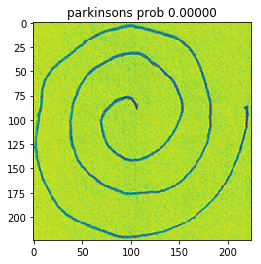

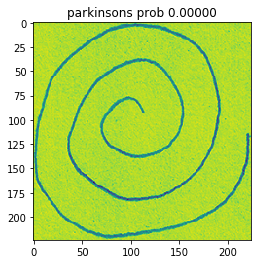

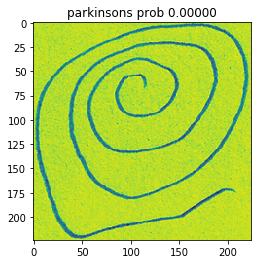

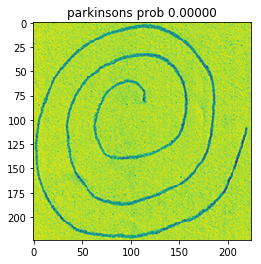

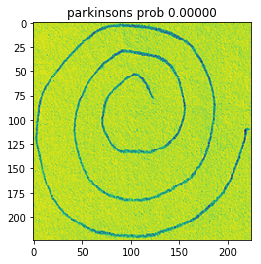

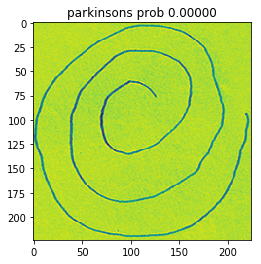

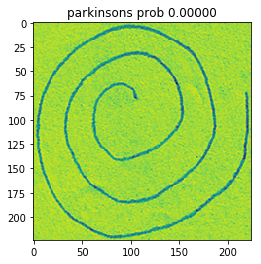

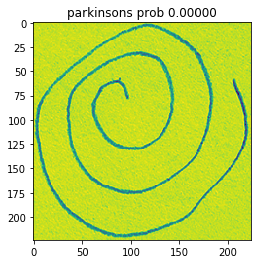

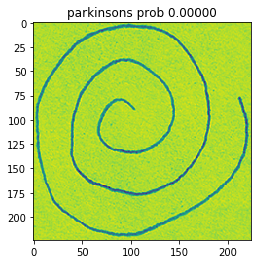

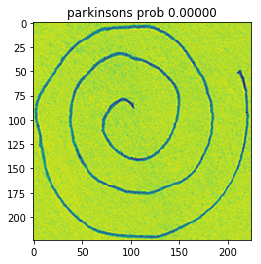

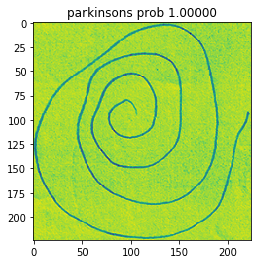

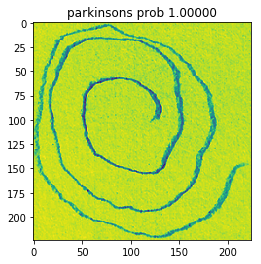

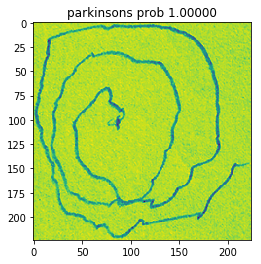

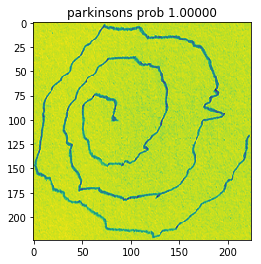

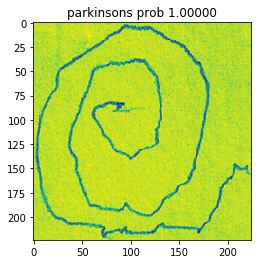

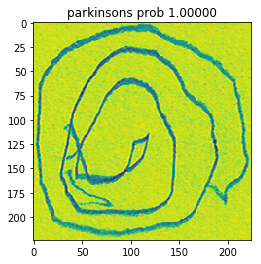

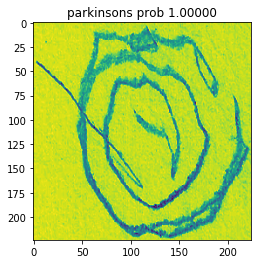

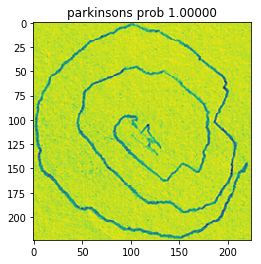

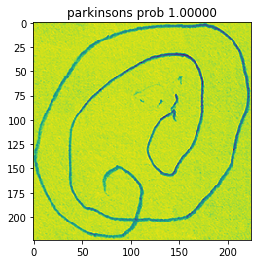

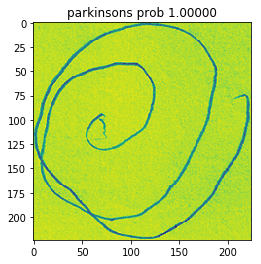

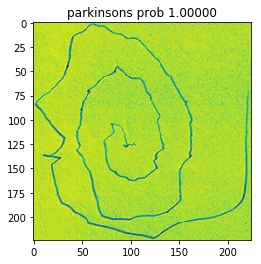

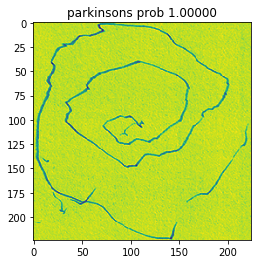

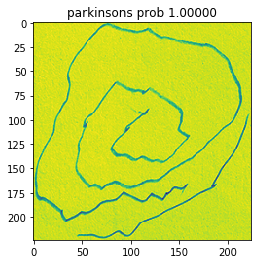

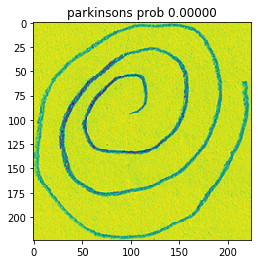

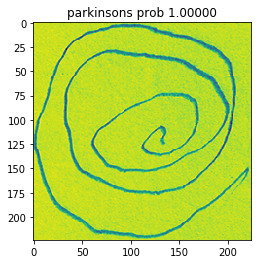

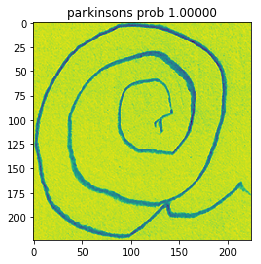

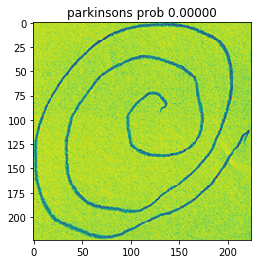

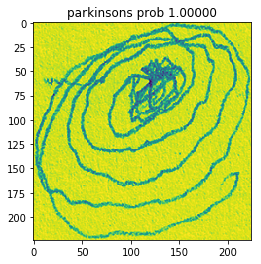

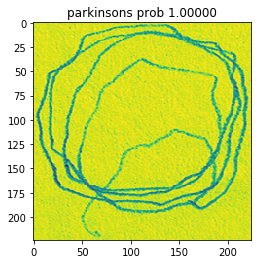

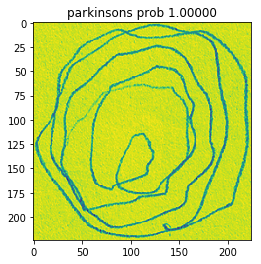

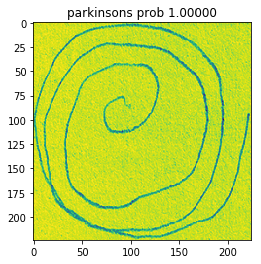

In [83]:
## plot sample data for visualization
testpath='C:/Users/zecharpy/Downloads/parkinsons/dataset/spiral/testing/'
healthy='healthy/'
parkinson='parkinson/'
healthy_ls= os.listdir(testpath+healthy)
parkinson_ls= os.listdir(testpath+parkinson)
#preprocessing data
import cv2
import matplotlib.pyplot as plt
import math
%matplotlib inline


def data_preprocessing2(img):
    #img=cv2.imread(im_path)
    img=cv2.resize(img,(224,224))
    img=img/255

    return np.expand_dims(img,axis=0)

                

for i in range(len(Xtest)):
    
  
    
    o1=m.predict(Xtest[i].reshape(1,224,224,1))

    o1=o1[0][0] if o1[0][0] >= 1e-2 else 0.00
    plt.imshow(np.squeeze(Xtest[i]))
    plt.title("parkinsons prob {:2.5f}".format(o1,2))
    plt.show()
